<a href="https://colab.research.google.com/github/nito5191/fingertip-over-keyboard-track/blob/main/examples/hand_landmarker/python/hand_landmarker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Copyright 2023 The MediaPipe Authors. All Rights Reserved.

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Hand Landmarks Detection with MediaPipe Tasks

This notebook shows you how to use MediaPipe Tasks Python API to detect hand landmarks from images.

## Preparation

Let's start with installing MediaPipe.

In [1]:
!pip install -q mediapipe

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.6/35.6 MB 19.3 MB/s eta 0:00:00


Then download an off-the-shelf model bundle. Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker#models) for more information about this model bundle.

In [2]:
!wget -q https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task

## Visualization utilities

In [3]:
#@markdown We implemented some functions to visualize the hand landmark detection results. <br/> Run the following cell to activate the functions.

from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np

MARGIN = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
HANDEDNESS_TEXT_COLOR = (88, 205, 54) # vibrant green

def draw_landmarks_on_image(rgb_image, detection_result):
  hand_landmarks_list = detection_result.hand_landmarks
  handedness_list = detection_result.handedness
  annotated_image = np.copy(rgb_image)

  # Loop through the detected hands to visualize.
  for idx in range(len(hand_landmarks_list)):
    hand_landmarks = hand_landmarks_list[idx]
    handedness = handedness_list[idx]

    # Draw the hand landmarks.
    hand_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    hand_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in hand_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      hand_landmarks_proto,
      solutions.hands.HAND_CONNECTIONS,
      solutions.drawing_styles.get_default_hand_landmarks_style(),
      solutions.drawing_styles.get_default_hand_connections_style())

    # Get the top left corner of the detected hand's bounding box.
    height, width, _ = annotated_image.shape
    x_coordinates = [landmark.x for landmark in hand_landmarks]
    y_coordinates = [landmark.y for landmark in hand_landmarks]
    text_x = int(min(x_coordinates) * width)
    text_y = int(min(y_coordinates) * height) - MARGIN

    # Draw handedness (left or right hand) on the image.
    cv2.putText(annotated_image, f"{handedness[0].category_name}",
                (text_x, text_y), cv2.FONT_HERSHEY_DUPLEX,
                FONT_SIZE, HANDEDNESS_TEXT_COLOR, FONT_THICKNESS, cv2.LINE_AA)

  return annotated_image

## Download test image

Let's grab a test image that we'll use later. The image is from [Unsplash](https://unsplash.com/photos/mt2fyrdXxzk).

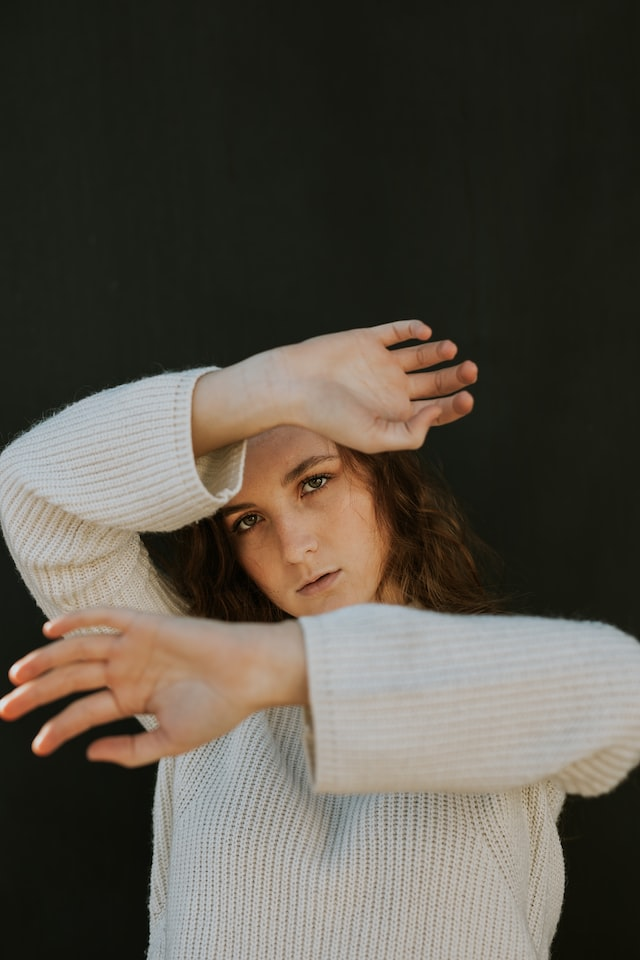

In [4]:
!wget -q -O image.jpg https://storage.googleapis.com/mediapipe-tasks/hand_landmarker/woman_hands.jpg

import cv2
from google.colab.patches import cv2_imshow

img = cv2.imread("image.jpg")
cv2_imshow(img)

Optionally, you can upload your own image. If you want to do so, uncomment and run the cell below.

In [4]:
from google.colab import files
uploaded = files.upload()

for filename in uploaded:
  content = uploaded[filename]
  with open(filename, 'wb') as f:
    f.write(content)

if len(uploaded.keys()):
  IMAGE_FILE = next(iter(uploaded))
  print('Uploaded file:', IMAGE_FILE)

Saving hand_test_1.jpg to hand_test_1.jpg
Uploaded file: hand_test_1.jpg


## Running inference and visualizing the results

Here are the steps to run hand landmark detection using MediaPipe.

Check out the [MediaPipe documentation](https://developers.google.com/mediapipe/solutions/vision/hand_landmarker/python) to learn more about configuration options that this solution supports.


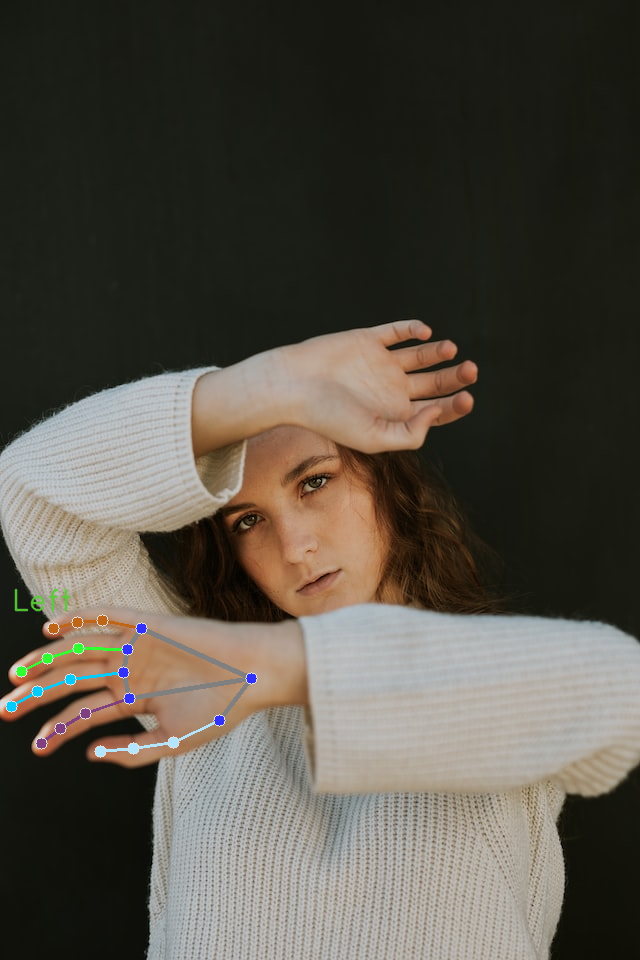

In [25]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an HandLandmarker object.
base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
options = vision.HandLandmarkerOptions(base_options=base_options,
                                       num_hands=1)
detector = vision.HandLandmarker.create_from_options(options)

def detect_and_display_hand_landmarks(image_path="image.jpg"): #"hand_test_1.jpg"):
  # STEP 3: Load the input image.
  image = mp.Image.create_from_file(image_path) #"image.jpg")

  # STEP 4: Detect hand landmarks from the input image.
  detection_result = detector.detect(image)

  # STEP 5: Process the classification result. In this case, visualize it.
  annotated_image = draw_landmarks_on_image(image.numpy_view(), detection_result)
  cv2_imshow(cv2.cvtColor(annotated_image, cv2.COLOR_RGB2BGR))

detect_and_display_hand_landmarks()

Camera capture

In [9]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

<IPython.core.display.Javascript object>

Saved to photo.jpg


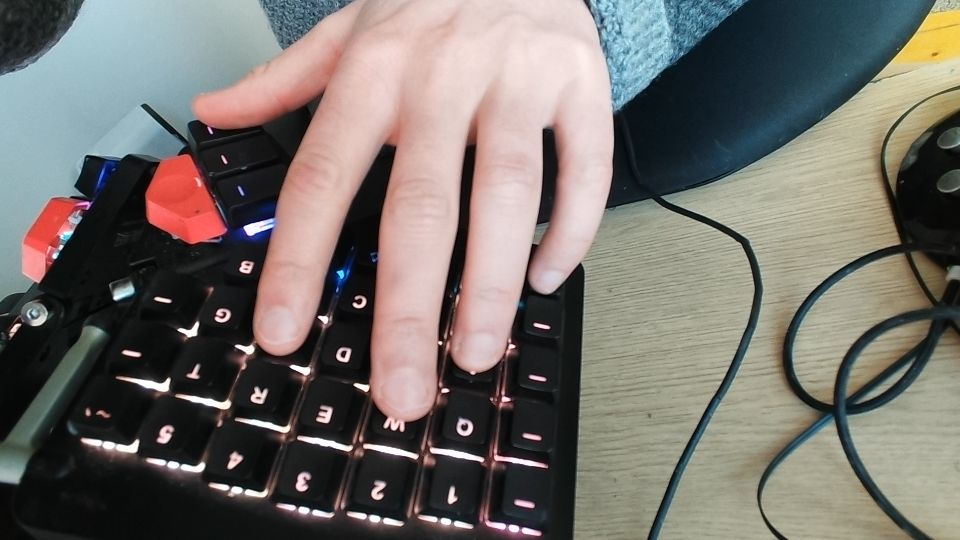

In [11]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

Video capture

In [69]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def record_video(filename='video.mp4', fps=60):
    """
    Records a video from the webcam with a specified FPS.

    Args:
        filename: The name of the file to save the video to.
        fps: The frames per second of the video (default: 60).
    """

    # This function uses the take_photo() function provided by the Colab team as a
    # starting point, along with a bunch of stuff from Stack overflow, and some sample code
    # from: https://developer.mozilla.org/enUS/docs/Web/API/MediaStream_Recording_API

    js = Javascript(f"""
        async function recordVideo() {{
            const options = {{ mimeType: "video/webm; codecs=vp9", frameRate: {fps} }};
            const div = document.createElement('div');
            const capture = document.createElement('button');
            const stopCapture = document.createElement("button");
            capture.textContent = "Start Recording";
            capture.style.background = "green";
            capture.style.color = "white";

            stopCapture.textContent = "Stop Recording";
            stopCapture.style.background = "red";
            stopCapture.style.color = "white";
            div.appendChild(capture);

            const video = document.createElement('video');
            const recordingVid = document.createElement("video");
            video.style.display = 'block';

            const stream = await navigator.mediaDevices.getUserMedia({{video: {{ frameRate: {{ ideal: {fps} }} }} }});
            let recorder = new MediaRecorder(stream, options);
            document.body.appendChild(div);
            div.appendChild(video);
            video.srcObject = stream;
            await video.play();

            // Resize the output to fit the video element.
            google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

            await new Promise((resolve) => {{
                capture.onclick = resolve;
            }});
            recorder.start();
            capture.replaceWith(stopCapture);
            await new Promise((resolve) => stopCapture.onclick = resolve);
            recorder.stop();

            let recData = await new Promise((resolve) => recorder.ondataavailable = resolve);
            let arrBuff = await recData.data.arrayBuffer();
            stream.getVideoTracks()[0].stop();
            div.remove();

            let binaryString = "";
            let bytes = new Uint8Array(arrBuff);
            bytes.forEach((byte) => {{
                binaryString += String.fromCharCode(byte);
            }})
            return btoa(binaryString);
        }}
    """)
    try:
        display(js)
        data = eval_js('recordVideo({})')
        binary = b64decode(data)
        with open(filename, "wb") as video_file:
            video_file.write(binary)
        print(
            f"Finished recording video. Saved binary under filename in current working directory: {filename}"
        )
    except Exception as err:
        # In case any exceptions arise
        print(str(err))
    return filename

In [74]:
fps=60

In [75]:
#record_video(fps=fps)

In [66]:
!ls -la video.mp4

-rw-r--r-- 1 root root 1071244 Feb 25 13:04 video.mp4


In [59]:
# !pip install moviepy

In [67]:
import subprocess

def get_fps_ffprobe(video_path):
    """
    Gets the FPS of a video file using ffprobe.

    Args:
        video_path: The path to the video file.

    Returns:
        The FPS of the video as a float, or None if an error occurs.
    """
    try:
        # Construct the ffprobe command
        command = [
            "ffprobe",
            "-v", "error",
            "-select_streams", "v:0",
            "-show_entries", "stream=r_frame_rate",
            "-of", "default=noprint_wrappers=1:nokey=1",
            video_path
        ]

        # Execute the command and capture the output
        result = subprocess.run(command, capture_output=True, text=True, check=True)

        # Parse the output
        frame_rate_str = result.stdout.strip()
        numerator, denominator = map(int, frame_rate_str.split('/'))
        fps = numerator / denominator
        return fps
    except subprocess.CalledProcessError as e:
        print(f"An error occurred with ffprobe: {e}")
    except ValueError as e:
        print(f"Could not parse ffprobe output: {e}")
    except FileNotFoundError as e:
        print(f"ffprobe not found. Is it installed?: {e}")
    except Exception as e:
      print(f"An unexpected error occurred: {e}")
    return None

get_fps_ffprobe("video.mp4")
# fps = get_fps_ffprobe("video.mp4")
# fps

1000.0

In [76]:
from google.colab.patches import cv2_imshow

def detect_and_display_hand_landmarks_on_video(video_path, output_path='output_video.mp4', fps=fps, num_hands=1):
    """
    Detects and displays hand landmarks on a video, saving the annotated video to a new file.

    Args:
        video_path (str): Path to the input video file.
        output_path (str): Path to save the output annotated video file.
        num_hands (int): The number of hands to detect.
    """
    try:
        # Initialize MediaPipe HandLandmarker
        base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
        options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=num_hands)
        detector = vision.HandLandmarker.create_from_options(options)

        # Open the video file
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError("Could not open video.")

        # Get video properties
        # fps = cap.get(cv2.CAP_PROP_FPS) # reads incorrect 1000
        width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        # Create a VideoWriter to save the output video
        fourcc = cv2.VideoWriter_fourcc(*'vp09') #'avc1') #'mp4v')  # Use 'mp4v' for .mp4 output
        out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
        print(f"Video stats:")
        print(f"Frame Rate: {fps}")
        print(f"Width: {width}")
        print(f"Height: {height}")

        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break  # End of video

            # Convert the frame to RGB for MediaPipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

            # Detect hand landmarks
            detection_result = detector.detect(mp_image)

            # Draw landmarks on the frame
            annotated_frame = draw_landmarks_on_image(rgb_frame, detection_result)

            # Write the frame to the output video
            out.write(cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))

            # Display live video (optional)
            # cv2_imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_RGB2BGR))
            # if cv2.waitKey(1) & 0xFF == ord('q'):
            #     break

        # Release resources
        cap.release()
        out.release()
        cv2.destroyAllWindows()

        print(f"Video with hand landmarks saved to {output_path}")

    except Exception as e:
        print(f"An error occurred: {e}")

# Example Usage:
input_video_file = "video.mp4" # replace with the correct video file
detect_and_display_hand_landmarks_on_video(input_video_file, output_path='annotated_video.mp4')

Video stats:
Frame Rate: 60
Width: 960
Height: 540
Video with hand landmarks saved to annotated_video.mp4


In [78]:
!ls -la annotated_video.mp4

-rw-r--r-- 1 root root 7426782 Feb 25 13:13 annotated_video.mp4


Final Finger Tip Positions (Geometric Median):
finger_4: (324.2929172515869, 279.84316527843475)
finger_8: (400.68424701690674, 423.01248729228973)
finger_12: (513.7009620666504, 452.4600040912628)
finger_16: (577.2483444213867, 412.352557182312)
finger_20: (650.0776290893555, 331.2577325105667)


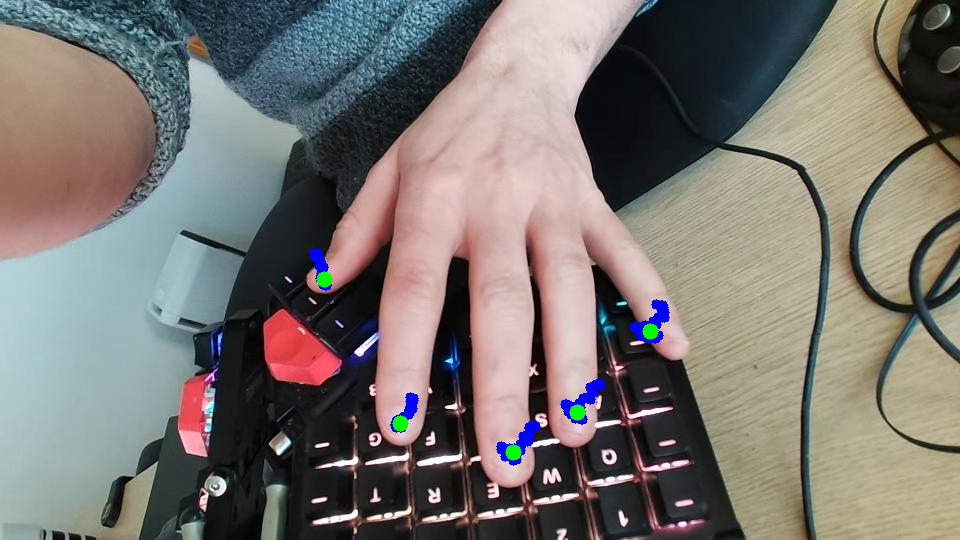

In [50]:
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import cv2
import numpy as np
import time

def geometric_median(points):
    """
    Calculates the geometric median of a set of points.

    Args:
        points: A list of (x, y) tuples or a NumPy array of shape (N, 2).

    Returns:
        A tuple (x, y) representing the geometric median.
    """
    if not points:
        return None

    points = np.array(points)
    y = np.median(points, axis=0)
    return tuple(y)

def collect_finger_positions_from_video(video_path, num_hands=1):
    """
    Collects finger tip positions from all frames of a video file
    and returns the geometric median position for each finger.

    Args:
        video_path: The path to the video file.
        num_hands: The number of hands to detect in the video.

    Returns:
        A tuple containing:
            - final_frame: The last captured frame as a NumPy array.
            - final_finger_positions: A dictionary where keys are finger names (e.g., "finger_4", "finger_8", ...)
                                      and values are the geometric median (x, y) positions of each finger.
            - all_finger_positions: A dictionary where keys are finger names and values are lists of all detected finger positions.
            Returns None, None, None if no hands are detected in the video or error in processing.
    """
    try:
        # Initialize MediaPipe HandLandmarker
        base_options = python.BaseOptions(model_asset_path='hand_landmarker.task')
        options = vision.HandLandmarkerOptions(base_options=base_options, num_hands=num_hands)
        detector = vision.HandLandmarker.create_from_options(options)

        # Open the video
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise ValueError(f"Could not open video at path {video_path}.")

        # Finger tip indices
        finger_tip_indices = [4, 8, 12, 16, 20]
        finger_names = [f"finger_{i}" for i in finger_tip_indices]
        all_finger_positions = {name: [] for name in finger_names}

        final_frame = None

        while True:  # Loop through all frames
            ret, frame = cap.read()
            if not ret:
                break  # End of video

            final_frame = frame.copy()

            # Convert the frame to RGB for MediaPipe
            rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb_frame)

            # Detect hand landmarks
            detection_result = detector.detect(mp_image)

            # Process hand landmarks
            if detection_result.hand_landmarks:
                for hand_landmarks in detection_result.hand_landmarks:
                    height, width, _ = frame.shape
                    for i, index in enumerate(finger_tip_indices):
                        landmark = hand_landmarks[index]
                        x = landmark.x * width
                        y = landmark.y * height
                        all_finger_positions[finger_names[i]].append((x, y))

        cap.release()

        # Calculate geometric median for each finger
        final_finger_positions = {}
        for finger_name, positions in all_finger_positions.items():
            median_position = geometric_median(positions)
            if median_position is not None:
                final_finger_positions[finger_name] = median_position

        if not final_finger_positions:
            return None, None, None

        return final_frame, final_finger_positions, all_finger_positions

    except Exception as e:
        print(f"An error occurred: {e}")
        return None, None, None

def overlay_finger_positions(frame, all_positions, median_positions):
    """
    Overlays all collected finger positions and the median points onto the frame.

    Args:
        frame: The image frame (NumPy array).
        all_positions: A dictionary where keys are finger names and values are lists of all detected finger positions.
        median_positions: A dictionary of the geometric median positions for each finger.

    Returns:
        The frame with the finger positions and medians overlaid.
    """
    annotated_frame = frame.copy()
    # Draw all finger positions in blue
    for finger_name, positions in all_positions.items():
        for x, y in positions:
            cv2.circle(annotated_frame, (int(x), int(y)), 5, (255, 0, 0), -1)  # Blue

    # Draw median positions in green
    for finger_name, (x, y) in median_positions.items():
        cv2.circle(annotated_frame, (int(x), int(y)), 8, (0, 255, 0), -1)  # Green

    return annotated_frame

# Example Usage:
video_file = "video.mp4" # Replace with your video file
final_frame, finger_positions, all_positions = collect_finger_positions_from_video(video_file, num_hands=1)

if final_frame is not None and finger_positions is not None and all_positions is not None:
    print("Final Finger Tip Positions (Geometric Median):")
    for finger, position in finger_positions.items():
        print(f"{finger}: {position}")

    annotated_frame = overlay_finger_positions(final_frame, all_positions, finger_positions)
    cv2_imshow(annotated_frame)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
else:
    print("No hands detected or error during processing.")

In [79]:
# Run the function, get the video path as saved in your notebook, and play it back here.
from IPython.display import HTML
from base64 import b64encode

video_width = 800

# video_path = record_video()
video_path = "video.mp4"
video_file = open(video_path, "r+b").read()

video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

In [80]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [86]:
!ls drive/MyDrive/code

AiOS  AiOS_app	mmdeploy  mmpose  rtmlib  tennis  tennis_video.mov


In [88]:
pwd

'/content'

In [89]:
!rsync -av --exclude='sample_data/' /content/ /content/drive/MyDrive/code/fingertip-over-keyboard-track/

sending incremental file list
created directory /content/drive/MyDrive/code/fingertip-over-keyboard-track
./
annotated_video.mp4
rsync: [generator] recv_generator: mkdir "/content/drive/MyDrive/code/fingertip-over-keyboard-track/drive/.Encrypted/.shortcut-targets-by-id" failed: Read-only file system (30)
*** Skipping any contents from this failed directory ***
rsync: [generator] recv_generator: mkdir "/content/drive/MyDrive/code/fingertip-over-keyboard-track/drive/.Encrypted/MyDrive" failed: Read-only file system (30)
*** Skipping any contents from this failed directory ***
hand_landmarker.task
image.jpg
photo.jpg
video.mp4
video.webm
.config/
.config/.last_opt_in_prompt.yaml
.config/.last_survey_prompt.yaml
.config/.last_update_check.json
.config/active_config
.config/config_sentinel
.config/default_configs.db
.config/gce
.config/hidden_gcloud_config_universe_descriptor_data_cache_configs.db
.config/configurations/
.config/configurations/config_default
.config/logs/
.config/logs/2025.